# A notebook to help you set up your BPE run

In [11]:
import os
import shutil

import cantera as ct
import yaml
import numpy as np
import pandas as pd

import scipy.interpolate
import matplotlib.pyplot as plt
%matplotlib inline


# 1. Set the working directory. Where do you want to make your new BPE run?

In [131]:
# working_dir = '/path/to/bpe/run'
# working_dir = '/home/moon/mk3/ct_example'  # <--------------------------- set working directory
working_dir = '/scratch/harris.se/guassian_scratch/mk3_runs/ct_20260128'  # <--------------------------- set working directory

# In this house we don't overwrite existing files
assert not os.path.exists(working_dir), f"Working directory {working_dir} already exists. Please choose a different one or delete it."
os.makedirs(working_dir)

# This is where we'll save the experimental data
experiment_csv = os.path.join(working_dir, 'experiment.csv')
experiment_uncertainty_csv = os.path.join(working_dir, 'experiment_uncertainty.csv')
prior_csv = os.path.join(working_dir, 'priors.csv')
prior_uncertainty_csv = os.path.join(working_dir, 'priors_uncertainty.csv')
sim_info_yaml = os.path.join(working_dir, 'sim_info.yaml')

# Copy the default run_bpe scripts into the working directory
UNCERTAINTY_REPO = os.environ['UNCERTAINTY_REPO']
base_run_bpe_py_script = os.path.join(UNCERTAINTY_REPO, 'bpe', 'simulation', 'run_bpe.py')
base_run_bpe_sh_script = os.path.join(UNCERTAINTY_REPO, 'bpe', 'simulation', 'run_bpe.sh')
shutil.copy(base_run_bpe_py_script, os.path.join(working_dir, 'run_bpe.py'))
shutil.copy(base_run_bpe_sh_script, os.path.join(working_dir, 'run_bpe.sh'))



'/home/moon/mk3/ct_example/run_bpe.sh'

# 2. Specify Cantera mechanism .yaml file

In [132]:
# mech_yaml = '/path/to/mechanism/yaml'
# mech_yaml = '/home/moon/chem_annotated_noCH4X.yaml'  # <--------------------------- set mechanism yaml
mech_yaml = '/home/harris.se/chem_annotated_noCH4X.yaml'  # <--------------------------- set mechanism yaml


# copy to working directory
shutil.copy(mech_yaml, os.path.join(working_dir, 'chem_annotated.yaml'))

# load the mechanism yaml to get the species and reaction information
gas = ct.Solution(mech_yaml)
surf = ct.Interface(mech_yaml, "surface1", [gas])

def get_i_thing(ref_composition, phase):
    """
    Get index of a requested Cantera species
    ref_composition is a dictionary of the atom counts
    phase is the cantera phase in which the species is stored
    """
    for i in range(phase.n_species):
        if phase.species()[i].composition == ref_composition:
            return i
    assert False

# Get indices of key species <-------------------------- you need to customize this set
# TODO generalize this a little more
i_Ar = get_i_thing({'Ar': 1.0}, gas)
i_CH4 = get_i_thing({'C': 1.0, 'H': 4.0}, gas)
i_O2 = get_i_thing({'O': 2.0}, gas)
i_CO2 = get_i_thing({'C': 1.0, 'O': 2.0}, gas)
i_H2O = get_i_thing({'H': 2.0, 'O': 1.0}, gas)
i_H2 = get_i_thing({'H': 2.0}, gas)
i_CO = get_i_thing({'C': 1.0, 'O': 1.0}, gas)
i_C2H4 = get_i_thing({'C': 2.0, 'H': 4.0}, gas)
i_X = get_i_thing({'X': 1.0}, surf)
i_OX = get_i_thing({'X': 1.0, 'O': 1.0}, surf)
i_CX = get_i_thing({'X': 1.0, 'C': 1.0}, surf)
i_CO2X = get_i_thing({'X': 1.0, 'C': 1.0, 'O': 2.0}, surf)
i_COX = get_i_thing({'X': 1.0, 'C': 1.0, 'O': 1.0}, surf)
i_HX = get_i_thing({'X': 1.0, 'H': 1.0}, surf)
i_CH3X = get_i_thing({'X': 1.0, 'H': 3.0, 'C': 1.0}, surf)
i_H2OX = get_i_thing({'X': 1.0, 'H': 2.0, 'O': 1.0}, surf)
i_H2X = get_i_thing({'X': 1.0, 'H': 2.0}, surf)


/tmp/ipykernel_26032/654448659.py:9: UserWarning: StickingRate::validate: 
Sticking coefficient is greater than 1 for reaction 'CH4(2) + 2 X(1) <=> CH3X(27) + HX(21)'
at T = 5000.0
at T = 10000.0

  surf = ct.Interface(mech_yaml, "surface1", [gas])


# 3. Pick species and reactions to optimize

In [133]:
# -------------- Pick the species/reactions you want to vary here -------- #
# TODO let user vary gas species/reactions
my_species_indices = []
my_reaction_indices = [0, 1, 2, 3, 4, 5, 13, 14]
# ------------------------------------------------------------------------ #
for i in my_species_indices:
    print(f'Will optimize species {i}:', surf.species_names[i])
for i in my_reaction_indices:
    print(f'Will optimize reaction {i}:', surf.reactions()[i].equation)

Will optimize reaction 0: O2(3) + 2 X(1) <=> 2 OX(25)
Will optimize reaction 1: CO(7) + X(1) <=> COX(23)
Will optimize reaction 2: H(12) + X(1) <=> HX(21)
Will optimize reaction 3: CO2(4) + X(1) <=> CO2X(22)
Will optimize reaction 4: CH3(10) + X(1) <=> CH3X(27)
Will optimize reaction 5: H2(6) + X(1) <=> H2X(30)
Will optimize reaction 13: CH4(2) + 2 X(1) <=> CH3X(27) + HX(21)
Will optimize reaction 14: CO2(4) + 2 X(1) <=> COX(23) + OX(25)


# 4. Set the experimental error

In [134]:
# experimental_error = 0.05  # <----------------------- set experimental error
experimental_error = 0.1  # <----------------------- set experimental error
MIN_EXP_ERROR = 1e-8

# 5. Make the experimental data CSV
This will be different for every experiment and require user implementation

Here's an example for a PFR with species concentrations

Here, we use interpolation to reduce the number of data points included for faster BPE

Text(0.5, 1.0, 'Experimental data and uncertainties')

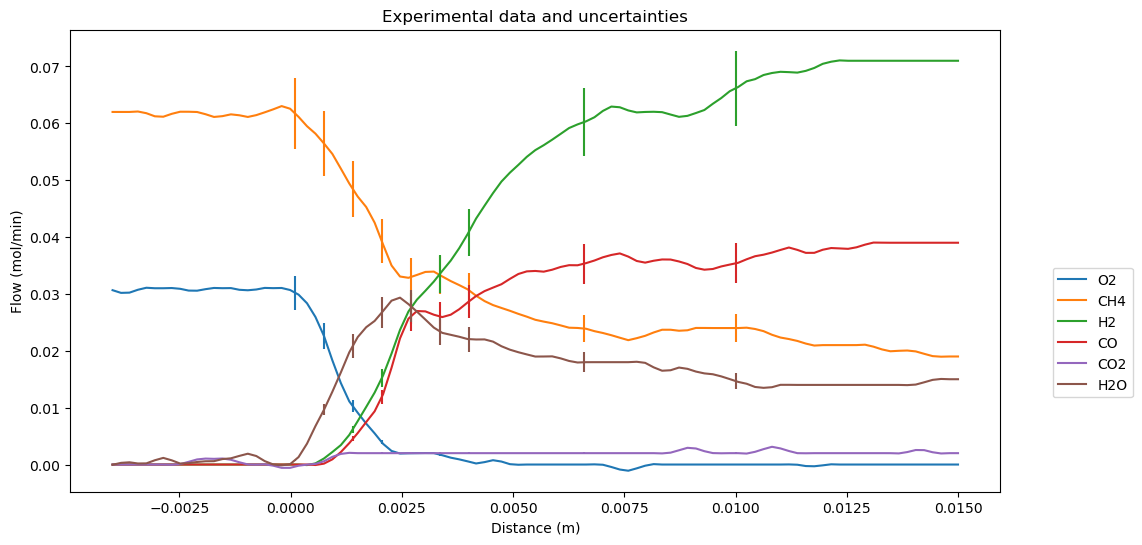

In [135]:
# Load the experimental data and save relevant info in experiment.yaml
pt_data_file = os.path.join(UNCERTAINTY_REPO, 'cpox_pt', 'horn_data', 'pt_profiles_smooth.csv')
df = pd.read_csv(pt_data_file)

# select distances manually to concentrate near start of reactor
sample_distances = np.concatenate((np.linspace(0.0001, 0.004, 7), np.array([0.0066, 0.01])))
# sample_distances = np.linspace(0, 0.01, 11)

# make an interpolation of each species concentration
species_headers = df.columns[2:]
experimental_data = np.zeros((len(sample_distances), len(species_headers)))
distances = (df['Distance (mm)'] - 10.0) / 1000.0  # ignore the 10mm of no/catalyst space
for i, header in enumerate(species_headers):
    exp_values = df[header]
    f = scipy.interpolate.interp1d(distances, exp_values, fill_value='extrapolate')
    experimental_data[:, i] = f(sample_distances)

# convert to DataFrame to save csv
experiment_df = pd.DataFrame(columns=species_headers, data=experimental_data)
experiment_df.to_csv(experiment_csv, index=False)

# Save experimental uncertainty as CSV
experiment_uncertainty_data = np.copy(experimental_data) * experimental_error
experiment_uncertainty_data[experiment_uncertainty_data < MIN_EXP_ERROR] = MIN_EXP_ERROR
experiment_uncertainty_df = pd.DataFrame(columns=species_headers, data=experiment_uncertainty_data)
experiment_uncertainty_df.to_csv(experiment_uncertainty_csv, index=False)

# Maybe save x values if we don't save them with the prior?

# ------------------------ Plot the experiment to show which points we picked ---------------#
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig = plt.figure()
fig.set_figheight(6)
fig.set_figwidth(12)

for i in range(len(species_headers)):
    plt.plot(distances, df[species_headers[i]], label=species_headers[i].split()[0], color=colors[i])
    plt.errorbar(
        sample_distances,
        experiment_df[species_headers[i]].values,
        yerr=experiment_uncertainty_df[species_headers[i]].values,
        color=colors[i],
        label='_no_label',
        fmt='none'
    )

plt.xlabel('Distance (m)')
plt.ylabel('Flow (mol/min)')
plt.legend(bbox_to_anchor=(1.15, 0.5))
plt.title('Experimental data and uncertainties')


# 6. Make the prior csv

In [136]:
prior_data = np.zeros((1, len(my_species_indices) + len(my_reaction_indices)))

# here, the parameters are how much we're changing thermo or kinetics from the original value, so all priors start as 0
param_names = []
for i in range(len(my_species_indices)):
    param_names.append(surf.species_names[i])
for i in range(len(my_reaction_indices)):
    param_names.append(surf.reactions()[i].equation)
prior_df = pd.DataFrame(columns=param_names, data=prior_data)
prior_df.to_csv(prior_csv, index=False)

# TODO, grab this from the RMG uncertainty tool
prior_uncertainty_data = np.zeros((1, len(my_species_indices) + len(my_reaction_indices)))

eV_to_j_mol = 96485
std_dev_thermo = 0.3 * eV_to_j_mol
std_dev_log10k = 3.0  # factor of 10, should translate into multiplier of 0.1 - 10

# prior_cov_J_mol = np.identity(n_sp + n_rxn) * np.float_power(std_dev_thermo, 2.0)  # for cov matrix form
# for i in range(n_sp, n_sp + n_rxn):
#     prior_cov_J_mol[i, i] = np.float_power(std_dev_log10k, 2.0)  # kinetics part of cov matrix

prior_std_J_mol = np.ones((1, len(param_names))) * std_dev_thermo  # for uncertainty (std_dev) list form
for i in range(n_sp, n_sp + n_rxn):
    prior_std_J_mol[0, i] = std_dev_log10k  # kinetics part of cov matrix

prior_uncertainty_df = pd.DataFrame(columns=param_names, data=prior_std_J_mol)
prior_uncertainty_df.to_csv(prior_uncertainty_csv, index=False)

# TODO - plot these thermo/kinetics uncertainties

# 7. Save a yaml file detailing the indices for priors and outputs

In [137]:
sim_info = {}

# save output indices for comparison with experimental results
out_gas_indices = [i_O2, i_CH4, i_H2, i_CO, i_CO2, i_H2O]
for i in range(len(out_gas_indices)):
    # check that these indices match up with the output order
    print(gas.species_names[out_gas_indices[i]], '\t', experiment_df.columns[i])

sim_info['out_gas_indices'] = out_gas_indices
sim_info['prior_species_indices'] = my_species_indices
sim_info['prior_reaction_indices'] = my_reaction_indices
sim_info['parameter_names'] = param_names
sim_info['out_gas_names'] = [experiment_df.columns[i].split()[0] for i in range(len(experiment_df.columns))]
sim_info['sample_distances'] = sample_distances.tolist()

with open(sim_info_yaml, 'w') as outfile:
    yaml.dump(sim_info, outfile, default_flow_style=False)

O2(3) 	 O2 (mol/min)
CH4(2) 	 CH4 (mol/min)
H2(6) 	 H2 (mol/min)
CO(7) 	 CO (mol/min)
CO2(4) 	 CO2 (mol/min)
H2O(5) 	 H2O (mol/min)


In [105]:
with open(sim_info_yaml) as f:
    data = yaml.safe_load(f)


In [106]:
data

{'out_gas_indices': [4, 3, 7, 8, 5, 6],
 'out_gas_names': ['O2', 'CH4', 'H2', 'CO', 'CO2', 'H2O'],
 'param_names': ['O2(3) + 2 X(1) <=> 2 OX(25)',
  'CO(7) + X(1) <=> COX(23)',
  'H(12) + X(1) <=> HX(21)',
  'CO2(4) + X(1) <=> CO2X(22)',
  'CH3(10) + X(1) <=> CH3X(27)',
  'H2(6) + X(1) <=> H2X(30)',
  'OH(17) + X(1) <=> OHX(31)',
  'H2O(5) + X(1) <=> H2OX(32)'],
 'prior_reaction_indices': [0, 1, 2, 3, 4, 5, 13, 14],
 'prior_species_indices': [],
 'sample_distances': [0.0001,
  0.0007500000000000001,
  0.0014000000000000002,
  0.00205,
  0.0027,
  0.00335,
  0.004,
  0.0066,
  0.01]}